# **Pneumonia, Viral vs. Bacterial**

Pneumonia is an inflammatory condition of the lung primarily affecting the small air sacs. Pneumonia is usually caused by infection with viruses or bacteria, and less commonly by other microorganisms. Identifying the responsible microorganism can target treatment and increase certainty of prognosis.

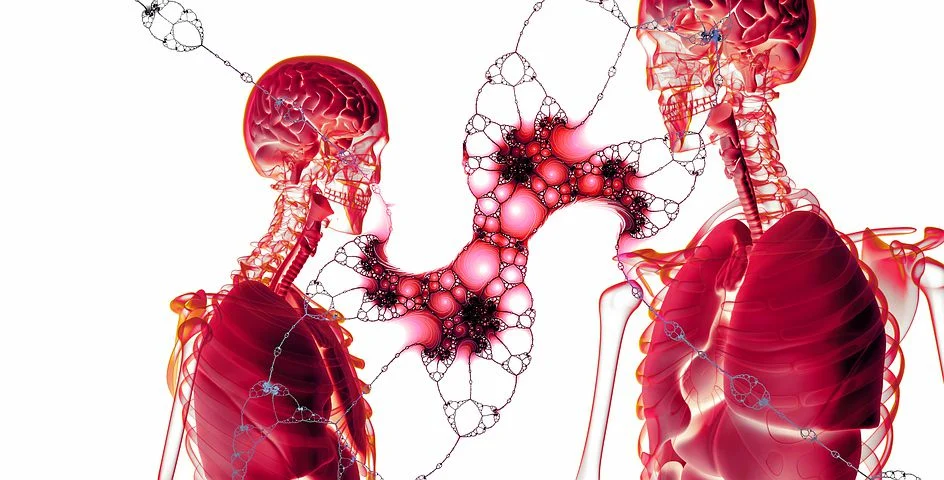

## Importing libraries

In [1]:
from pathlib import Path
import os, shutil, time
from skimage import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

import keras
from keras.applications import VGG16
from keras import models, layers, optimizers
from keras.optimizers import Nadam
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc ,confusion_matrix, classification_report
import cv2


## Finding pictures

In [2]:
dir_labels = ['PNEUMONIA', 'NORMAL']
img_size = 224
def get_training_data(data_dir):
    data = [] 
    for label in dir_labels: 
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                if label == 'NORMAL':
                    data.append([resized_arr, 0])
                if label == 'PNEUMONIA':
                    if 'virus' in img:
                        data.append([resized_arr, 1])
                    if 'bacteria' in img:
                        data.append([resized_arr, 2])
            except Exception as e:
                print(e)
    return np.array(data)

In [11]:
train = get_training_data('chest-xray-pneumonia/train')
test = get_training_data('../kaggle/input/chest-xray-pneumonia/test')
val = get_training_data('../kaggle/input/chest-xray-pneumonia/val')

FileNotFoundError: [Errno 2] No such file or directory: 'chest-xray-pneumonia/train/PNEUMONIA'

In [4]:
labels = ['Normal', 'Viral','Bacterial']

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)


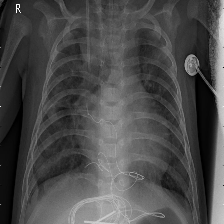

In [5]:
for i in range(1):
    fig = px.imshow(x_train[i], color_continuous_scale='gray', title=labels[y_train[i]])
    fig.show()

In [6]:
# Normalize the data
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

In [7]:
df_train = pd.DataFrame(y_train)
df_train = pd.DataFrame(df_train.value_counts(), columns=['Train'])
df_val = pd.DataFrame(y_val)
df_val = pd.DataFrame(df_val.value_counts(), columns=['Val'])
df_test = pd.DataFrame(y_test)
df_test = pd.DataFrame(df_test.value_counts(), columns=['Test'])

df_train = df_train.join([df_test, df_val])
df_train = df_train.reset_index().T.drop([0])
df_train.columns = ['Bacterial', 'Viral', 'Normal']

fig = px.bar(df_train)
fig.show()

columns = df_train.columns
index = df_train.index

fig = go.Figure(data=[
    go.Bar(name=index[0], x=columns, y=df_train.iloc[0]),
    go.Bar(name=index[1], x=columns, y=df_train.iloc[1]),
    go.Bar(name=index[2], x=columns, y=df_train.iloc[2])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

columns = df_train.columns
index = df_train.index

fig = go.Figure(data=[
    go.Bar(name=columns[0], x=index, y=df_train.iloc[:,0]),
    go.Bar(name=columns[1], x=index, y=df_train.iloc[:,1]),
    go.Bar(name=columns[2], x=index, y=df_train.iloc[:,2])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

## Importing VGG16 model

In [8]:
conv_base = VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape=(img_size, img_size, 3))

58892288/58889256 [==============================] - 2s 0us/step


In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Adding top layers

In [10]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 7

In [11]:
len(model.trainable_weights)

32

## Freezing

In order to take advantage of the VGG16 model, while still enabeling the model to adapt to the new data i want to keep most of the model as it is, and only letting the top layers adjust to the trainning data.
This is done by freezing all layers from bottom to "block5_conv1" ("set_traninable" as False) and activating layers above ("set_traninable" as True).

In [12]:
conv_base.trainable = True

set_traninable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_traninable = True
    if set_traninable:
        layer.traninable = True
    else:
        layer.trainable = False

len(model.trainable_weights)

12

## Image Data Generator
The image data generator makes it easy to import the pictures from directories in batches and also to do image augmentation. Since x-rays are produced in a uniform format rotation_range are set to 10 and horizontal_flip is set to False.

In [13]:
datagen = ImageDataGenerator(rescale=1./224,
                                  rotation_range=10,
                                  width_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=False,
                                  fill_mode='nearest')
datagen.fit(x_train)

In [14]:
time_start = time.process_time()

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='sgd',  #optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

callbacks_list = [keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3)]

history = model.fit(datagen.flow(x_train,y_train, batch_size = 50),
                    steps_per_epoch=100, 
                    epochs=16,
                    validation_data=datagen.flow(x_val, y_val, batch_size = 40),
                    validation_steps=1,
                    callbacks=callbacks_list)


time_end = time.process_time()
print(f'\n\nIt took: {(time_end-time_start)/60} min')

px.line(history.history)

Epoch 1/16
100/100 [==============================] - 53s 493ms/step - loss: 1.1380 - acc: 0.4840 - val_loss: 0.9555 - val_acc: 0.6875
Epoch 2/16
100/100 [==============================] - 48s 479ms/step - loss: 0.6587 - acc: 0.7052 - val_loss: 1.1848 - val_acc: 0.4375
Epoch 3/16
100/100 [==============================] - 48s 476ms/step - loss: 0.5797 - acc: 0.7482 - val_loss: 1.3856 - val_acc: 0.5000
Epoch 4/16
100/100 [==============================] - 48s 481ms/step - loss: 0.5341 - acc: 0.7679 - val_loss: 1.1802 - val_acc: 0.5000
Epoch 5/16
100/100 [==============================] - 47s 471ms/step - loss: 0.5236 - acc: 0.7729 - val_loss: 1.4734 - val_acc: 0.3750
Epoch 6/16
100/100 [==============================] - 48s 476ms/step - loss: 0.5072 - acc: 0.7754 - val_loss: 0.6558 - val_acc: 0.6250
Epoch 7/16
100/100 [==============================] - 47s 471ms/step - loss: 0.4949 - acc: 0.7902 - val_loss: 1.0144 - val_acc: 0.5625
Epoch 8/16
100/100 [==============================] - 4

In [15]:
px.line(history.history['acc'])

In [16]:
px.line(history.history['loss'])

In [17]:
px.line(history.history['val_acc'])

In [18]:
val_loss, val_acc = model.evaluate(x_test, y_test)

20/20 [==============================] - 2s 59ms/step - loss: 17.4475 - acc: 0.6282


In [19]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis = 1)

In [20]:
print(classification_report(y_test, y_pred, target_names = labels))

              precision    recall  f1-score   support

      Normal       0.67      0.79      0.72       234
       Viral       0.48      0.80      0.60       148
   Bacterial       0.90      0.37      0.52       242

    accuracy                           0.63       624
   macro avg       0.68      0.65      0.61       624
weighted avg       0.71      0.63      0.62       624



In [21]:
cm = confusion_matrix(y_test, y_pred)

fig = ff.create_annotated_heatmap(cm, x=labels, y=labels, colorscale='mint')

fig.update_layout(title_text='<b>Confusion matrix</b>',
                  xaxis = dict(title='Predicted value'),
                  yaxis = dict(title='Real value')
                 )
fig['layout']['yaxis']['autorange'] = "reversed"
fig.show()


In [22]:
y_pred = y_pred.reshape(1,-1)[0]

In [23]:
correct = np.nonzero(y_pred == y_test)[0]
incorrect = np.nonzero(y_pred != y_test)[0]
print(f'Number of incorrect classified images: {len(incorrect)} ~ {round(len(incorrect)/len(y_test)*100,1)}% \nNumber of correct classified images: {len(correct)} ~ {round(len(correct)/len(y_test)*100,1)}%')

correct_normal = np.sum(np.logical_and(y_pred == 0, y_test == 0))
incorrect_normal = np.sum(np.logical_and(y_pred == 0, y_test != 0))
correct_viral = np.sum(np.logical_and(y_pred == 1, y_test == 1))
incorrect_viral = np.sum(np.logical_and(y_pred == 1, y_test != 1))
correct_bac = np.sum(np.logical_and(y_pred == 2, y_test == 2))
incorrect_bac = np.sum(np.logical_and(y_pred == 2, y_test != 2))

print(f'\nNumber of images correctly classified as normal: {correct_normal}')
print(f'Number of images incorrectly classified as normal: {incorrect_normal}')
print(f'Number of images correctly classified as viral: {correct_viral}')
print(f'Number of images incorrectly classified as viral: {incorrect_viral}')
print(f'Number of images correctly classified as bacterial: {correct_bac}')
print(f'Number of images incorrectly classified as bacterial: {incorrect_bac}')



Number of incorrect classified images: 232 ~ 37.2% 
Number of correct classified images: 392 ~ 62.8%

Number of images correctly classified as normal: 185
Number of images incorrectly classified as normal: 93
Number of images correctly classified as viral: 118
Number of images incorrectly classified as viral: 129
Number of images correctly classified as bacterial: 89
Number of images incorrectly classified as bacterial: 10


As a sanity check lets look at the predictions and ground truths. 

In [24]:
i=0
for c in incorrect:
    print(y_pred[c])
    print(y_test[c],'\n')
    i += 1
    if i == 4:
        break

0
1 

0
2 

0
1 

0
2 




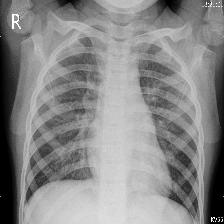


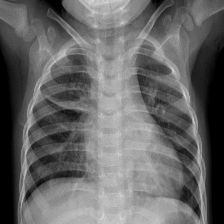

In [25]:
i=0

for c in incorrect:
    if y_pred[c] == 0: 
        predicted = 'Normal'
    if y_pred[c] == 1: 
        predicted = 'Viral'
    if y_pred[c] == 2: 
        predicted = 'Bacterial'    
    if y_test[c] == 0: 
        GT = 'Normal'
    if y_test[c] == 1: 
        GT = 'Viral'
    if y_test[c] == 2: 
        GT = 'Bacterial'
    fig = px.imshow(x_test[c][:][:][:], title=f'Groundtruth: {GT} <br>Predicted: {predicted}')
    fig.show()
    i += 1
    if i == 2:
        break